In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_theme()
pd.options.display.float_format = None

# https://www.kaggle.com/datasets/beatafaron/fmcg-daily-sales-data-to-2022-2024

In [2]:
def read_data():
    data = pd.read_csv(r"C:\Users\flori\Documents\Github\Forecasting\sales_forecasting\data\FMCG_2022_2024.csv")
    return data

data = read_data()

# 1 Data Wrangling

In [3]:
# Convert date into datetime and set as index
def convert_date(df):
    # Convert into datetime
    df["date"] = pd.to_datetime(df["date"])
    # Set as index
    df = df.set_index("date")

    return df

data = convert_date(data)

In [4]:
# Inspect Object Characteristics
for i in data.columns:
    if data[i].dtype == 'object':
        print(f"{i}: \n {data[i].unique()} \n")

sku: 
 ['MI-006' 'MI-026' 'YO-029' 'YO-005' 'YO-012' 'YO-014' 'YO-001' 'RE-004'
 'RE-007' 'RE-015' 'MI-023' 'JU-021' 'YO-009' 'SN-027' 'YO-003' 'MI-022'
 'YO-016' 'RE-025' 'SN-010' 'RE-017' 'SN-013' 'YO-020' 'SN-019' 'MI-002'
 'MI-011' 'YO-024' 'MI-008' 'SN-028' 'YO-018' 'SN-030'] 

brand: 
 ['MiBrand1' 'MiBrand4' 'YoBrand4' 'YoBrand2' 'YoBrand1' 'YoBrand3'
 'ReBrand1' 'ReBrand4' 'MiBrand3' 'JuBrand3' 'SnBrand2' 'ReBrand2'
 'SnBrand3' 'MiBrand2'] 

segment: 
 ['Milk-Seg3' 'Milk-Seg2' 'Yogurt-Seg2' 'Yogurt-Seg1' 'Yogurt-Seg3'
 'ReadyMeal-Seg2' 'ReadyMeal-Seg1' 'Juice-Seg3' 'SnackBar-Seg3'
 'ReadyMeal-Seg3' 'SnackBar-Seg2' 'SnackBar-Seg1' 'Milk-Seg1'] 

category: 
 ['Milk' 'Yogurt' 'ReadyMeal' 'Juice' 'SnackBar'] 

channel: 
 ['Retail' 'Discount' 'E-commerce'] 

region: 
 ['PL-Central' 'PL-North' 'PL-South'] 

pack_type: 
 ['Multipack' 'Single' 'Carton'] 



In [5]:
# Check Missing Values
data.isnull().sum().sum()

0

In [6]:
# Check Duplicates
data.duplicated().sum()

0

In [7]:
# Check for negative values
for i in data.columns:
    if data[i].dtype in ("int64", "int32","float64"):
        print(f"{i}: {(data[i] < 0).any()}")

price_unit: False
promotion_flag: False
delivery_days: False
stock_available: True
delivered_qty: True
units_sold: True


In [8]:
# Delete negative values
data = data[~data["delivered_qty"] < 0]

# 2 Exploratory Data Analysis

In [9]:
# Resample Data
data_resample_daily = data["units_sold"].resample("D").sum().copy()

## 2.1 Target

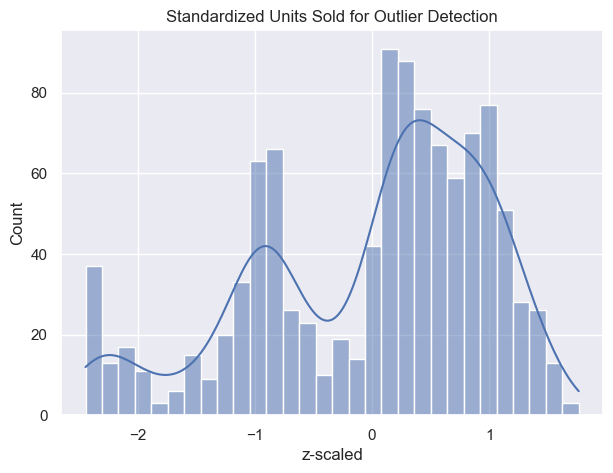

In [10]:
# Outlier Detection Units Sold
from sklearn.preprocessing import StandardScaler

# Instanciate Scaler
scaler = StandardScaler()

# Reshape Array
data_resample_daily_reshape = np.array(data_resample_daily).reshape(-1,1)

# Fit Transform
data_resample_daily_scaled = scaler.fit_transform(data_resample_daily_reshape).flatten()

# Plot
plt.figure(figsize=(7,5))
sns.histplot(data=data_resample_daily_scaled, bins=30, kde=True)
plt.title("Standardized Units Sold for Outlier Detection")
plt.xlabel("z-scaled");

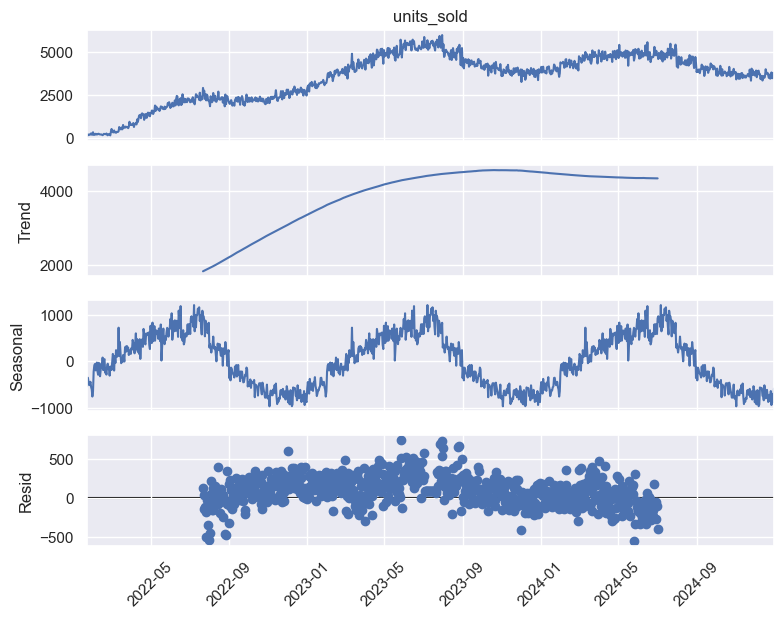

In [11]:
# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data_resample_daily, model="additive", period=365)
plt.rcParams["figure.figsize"] = (8,6)
result.plot()
plt.xticks(rotation=45);

In [ ]:
# Check for Stationarity: ADF-Test
trend = result.trend
seasonal = result.seasonal

# data_decomposed = (data_resample_daily - trend - seasonal).dropna()

# from statsmodels.tsa.stattools import adfuller

# adf_test = adfuller(data_decomposed)
# print("ADF Statistics:", adf_test[0])
# print("p-value:", adf_test[1])
# for key, value in adf_test[4].items():
#     print(f"{key}: {value}")

In [33]:
# Erste Differenz der dekomponierten Daten bilden
data_diff = data_resample_daily.diff(1).dropna()

# Erneuter ADF-Test
from statsmodels.tsa.stattools import adfuller
result_adf = adfuller(data_diff)
print(f'p-value: {result_adf[1]}')

p-value: 3.462126716900261e-29


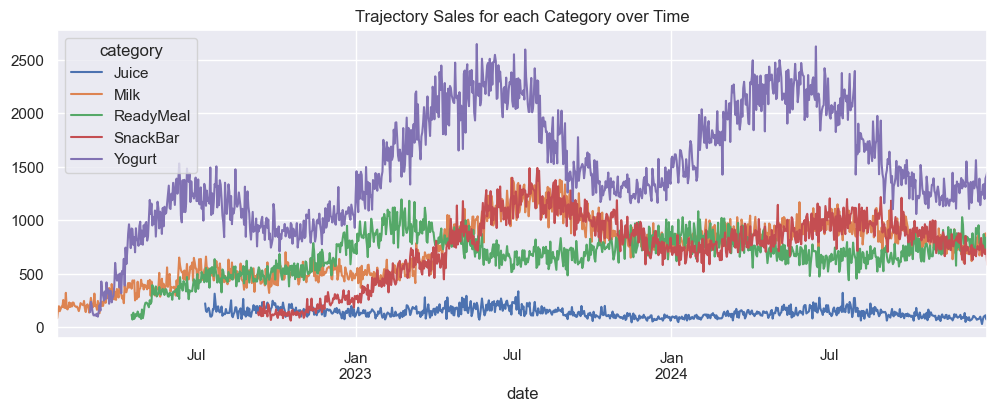

In [13]:
# Influence of Categories on Units Sold
daily_sales_each_category = data.groupby([pd.Grouper(freq="D"),"category"])["units_sold"].sum().unstack() \
.plot(figsize=(12,4), title="Trajectory Sales for each Category over Time")

### 2.1.2 Random Weekly Distribution

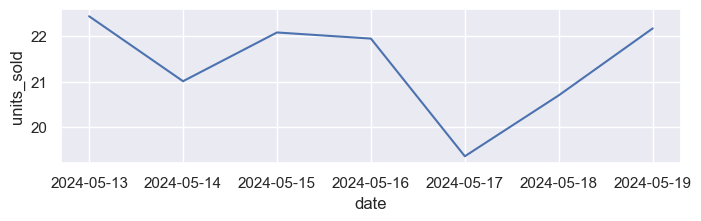

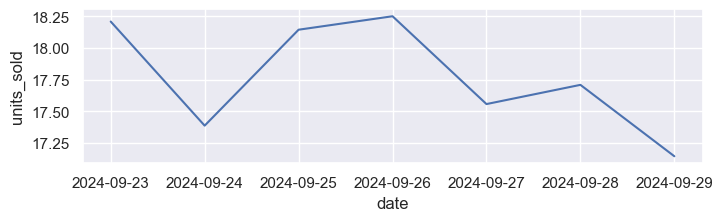

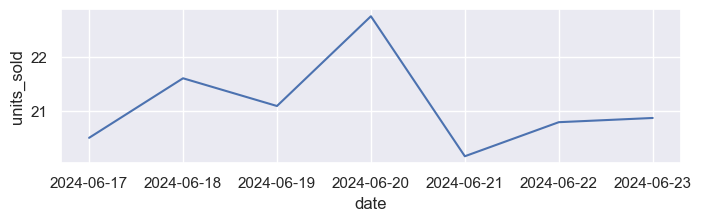

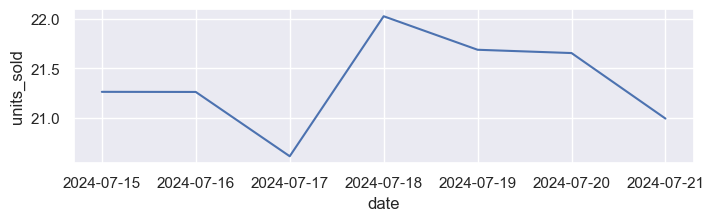

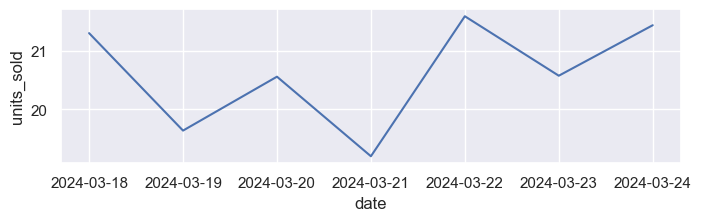

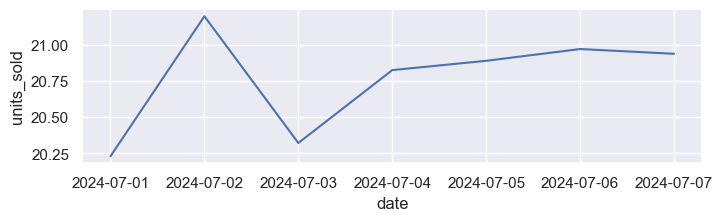

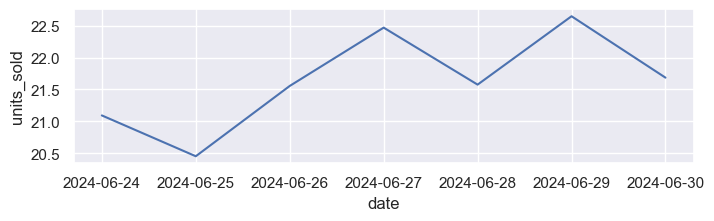

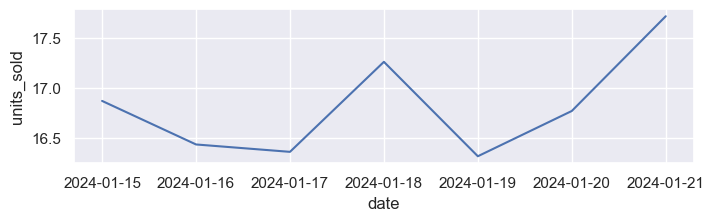

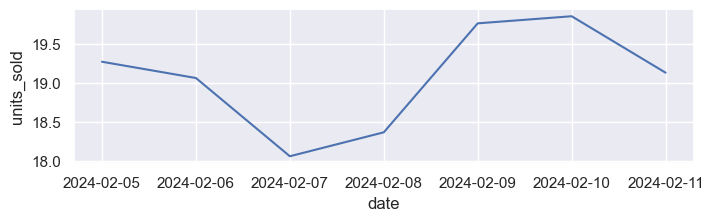

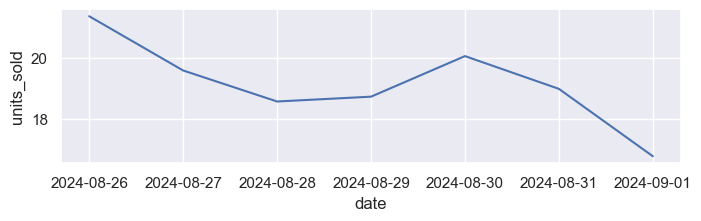

In [14]:
'''
This code samples 10 random weeks to explore weekly patterns

'''

# New Column 'Week'
data["week"] = data.index.isocalendar().week

# Index '2024'
data_2024 = data.loc["2024"]

# Random Samples of Weeks
sample_weeks = []

np.random.seed(42)
for _ in range(10):
    weeks = data_2024.week.unique()
    sample = np.random.choice(weeks, replace=False)
    sample_df = data_2024[data_2024.week == sample]
    sample_weeks.append(sample_df)

# Plot Weekly Distribution
for i in sample_weeks:
    plt.figure(figsize=(8,2))
    sns.lineplot(data=i, x=i.index, y="units_sold", errorbar=None)

### 2.1.3 Autocorrelation

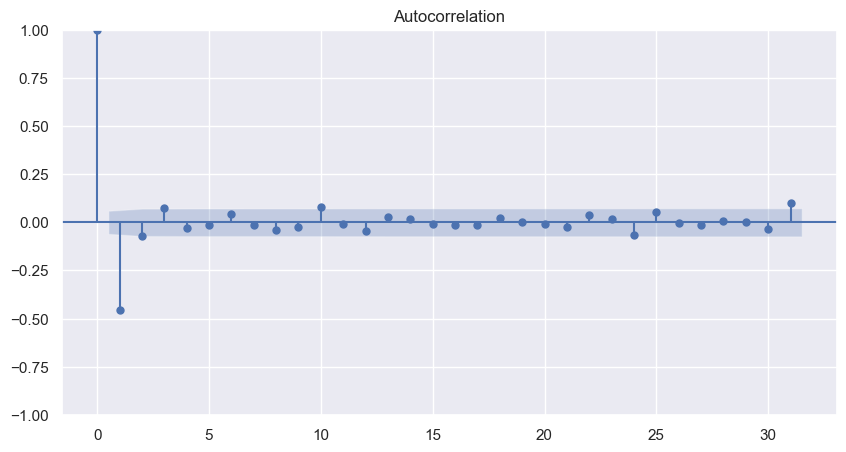

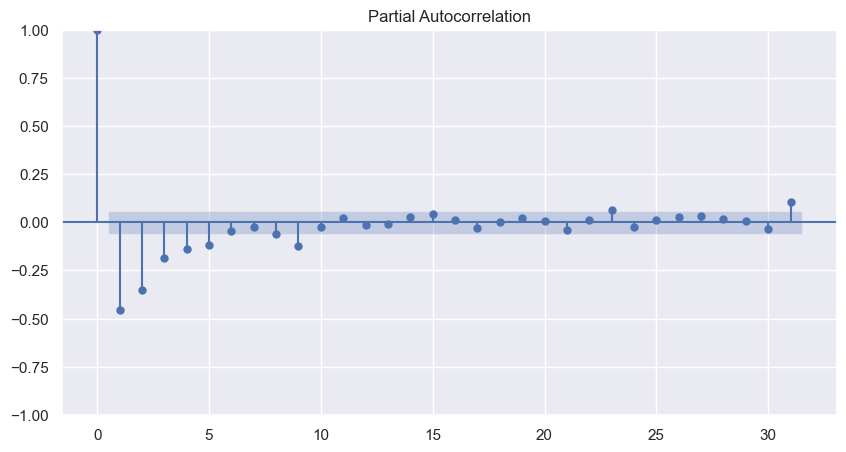

In [36]:
# (Partial) Autocorrelation Function (ACF, PCAF)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF/PACF Plot
plt.rcParams["figure.figsize"] = (10,5)
# ACF / PACF der differenzierten Daten
acf_plot = plot_acf(data_diff)
pacf_plot = plot_pacf(data_diff)

## 2.2 Features

### 2.2.1 Distribution Region, Channel, Pack Type, Promotion Flag

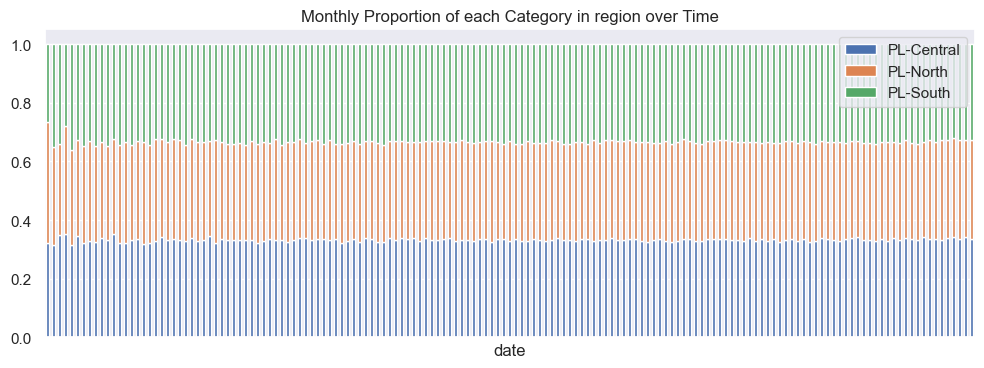

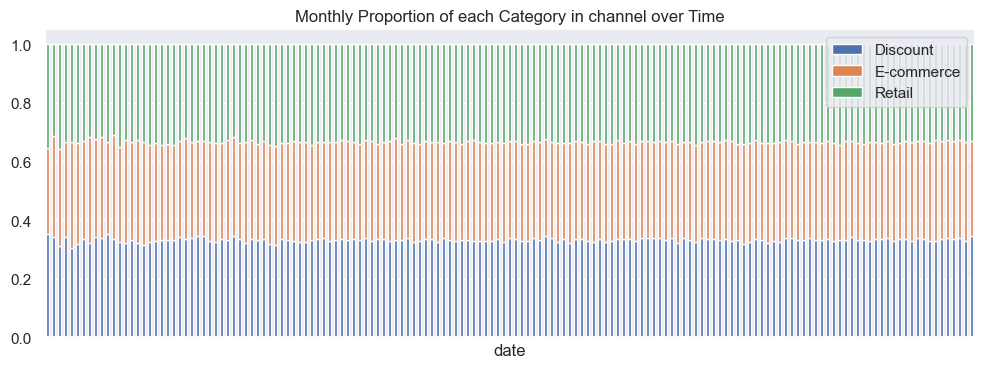

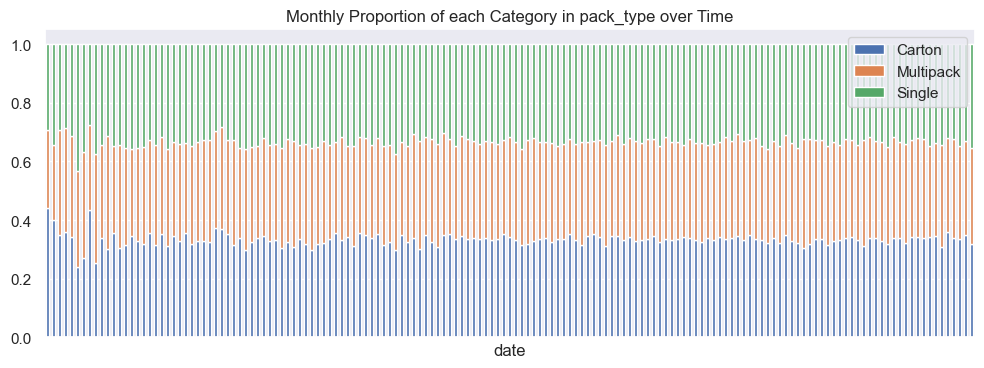

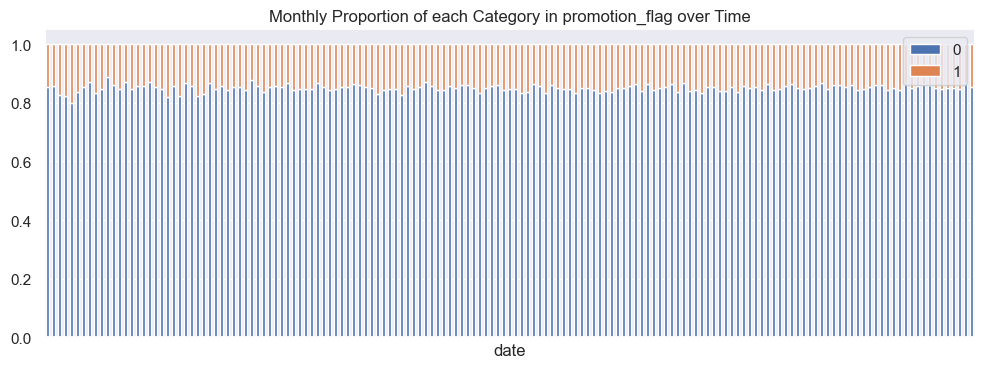

In [16]:
for col in ["region", "channel", "pack_type", "promotion_flag"]:
    data.groupby(pd.Grouper(freq="W"))[col] \
      .value_counts(normalize=True) \
      .unstack() \
      .plot(kind="bar",
      figsize=(12,4),
      stacked=True,
      title=f"Monthly Proportion of each Category in {col} over Time")
    plt.legend(loc="upper right")
    plt.xticks(ticks=np.arange(0, 0));
    

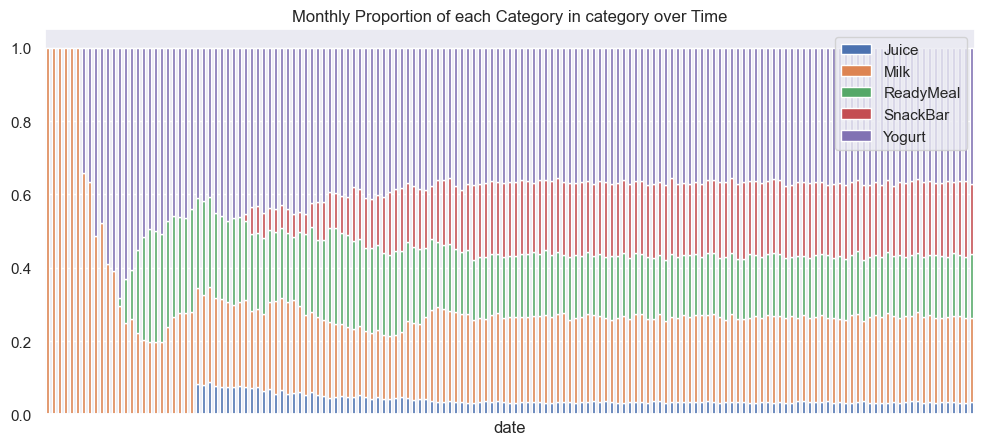

In [17]:
for col in ['category']:
    data.groupby(pd.Grouper(freq="W"))[col] \
      .value_counts(normalize=True) \
      .unstack() \
      .plot(kind="bar",
      figsize=(12,5),
      stacked=True,
      title=f"Monthly Proportion of each Category in {col} over Time")
    plt.legend(loc="upper right")
    plt.xticks(ticks=np.arange(0, 0));

### 2.2.2 Analysis Price Unit

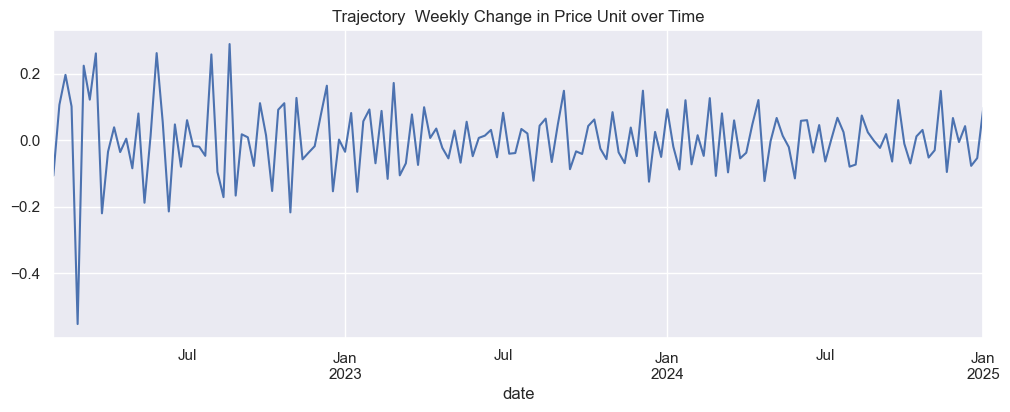

In [18]:
change_price_unit = data.price_unit.resample("W") \
.mean() \
.diff() \
.dropna() \
.plot(figsize=(12,4), title="Trajectory  Weekly Change in Price Unit over Time")